In [363]:
import os
import sys
import urllib.request
from io import BytesIO
from zipfile import ZipFile

import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dbfread import DBF
from IPython.display import display

# Google OR tools
from ortools.linear_solver import pywraplp

pd.set_option("display.max_columns", None)

## Importing Data


### Field Data


In [364]:
# Importing the field_dataset from the csv file
filepath = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/fields_prod_emissions_1997_2023.csv"

# Creating a check if import is successful
try:
    field_data = pd.read_csv(filepath, sep=",")
    print("Data import successful")
    field_data = field_data.rename(
    columns={
        "share_intensity_tco2e/toe_gwp100": "emission_intensity_distributed",
        "kgco2e/toe_int_gwp100": "emission_intensity",
        "total_emissions": "predicted_emissions"
    }
    )   

    # Year is %Y datetime
    field_data["year"] = pd.to_datetime(field_data["year"], format="%Y")
except:
    print("field_data import failed")
    



Data import successful


### Geolocations


In [365]:
# Define the URLs for the shapefile components
base_url = "https://github.com/percw/Norwegian_oil_gas_decarbonization/tree/main/data/raw_data/geo/fields/"
shapefile_components = ["fldArea.shp", "fldArea.shx", "fldArea.dbf"]

# Local directory to save downloaded files
local_dir = "../../data/raw_data/geo/fields"

# Function to download a file from a URL to a local path
def download_file(url, local_path):
    urllib.request.urlretrieve(url, local_path)

# Download the shapefile components if they do not exist locally
if not os.path.exists(local_dir):
    os.makedirs(local_dir)
    for component in shapefile_components:
        local_path = os.path.join(local_dir, os.path.basename(component))
        download_file(base_url + component, local_path)
else:
    print("Field data already exists")

# Function to read shapefile into GeoPandas
def import_field_data():
    fields = gpd.read_file(os.path.join(local_dir, "fldArea.shp"))
    return fields

# Import field data
fields = gpd.read_file('../../data/raw_data/geo/fields/fldArea.shp')

# Now, `fields` contains the GeoDataFrame with the field data
print(fields.head())

Field data already exists
          fieldName curActStat discWelNam  discYear  \
0        ALBUSKJELL  Shut down      1/6-1      1972   
1  TOMMELITEN GAMMA  Shut down      1/9-4      1978   
2              VARG  Shut down    15/12-4      1984   
3     SLEIPNER VEST  Producing     15/6-3      1974   
4            GUNGNE  Producing    15/9-15      1982   

                  owner_kind          owner_name  idOwner  \
0         PRODUCTION LICENSE                 018    20900   
1  BUSINESS ARRANGEMENT AREA     TOMMELITEN UNIT    41411   
2                        NaN                 NaN        0   
3  BUSINESS ARRANGEMENT AREA  SLEIPNER VEST UNIT    40848   
4         PRODUCTION LICENSE                 046    21156   

                      OpLongName  idCompany fldSupBase          Dctype  \
0  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
1  ConocoPhillips Skandinavia AS    2410696        NaN  GAS/CONDENSATE   
2                            NaN          0   Tananger

In [366]:
# Convert fieldName to lowercase
fields["fieldName"] = fields["fieldName"].str.lower()
fields.head(3)

,fieldName,curActStat,discWelNam,discYear,owner_kind,owner_name,idOwner,OpLongName,idCompany,fldSupBase,Dctype,main_area,discWelUrl,MapUrl,FactUrl,idWellbore,idField,dtUpdated,dtUpdMax,geometry
0,albuskjell,Shut down,1/6-1,1972,PRODUCTION LICENSE,018,20900,ConocoPhillips Skandinavia AS,2410696,NaN,GAS/CONDENSATE,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,239,43437,2024-01-02,2024-01-02,"POLYGON ((2.90643 56.65801, 2.90645 56.65801, ..."
1,tommeliten gamma,Shut down,1/9-4,1978,BUSINESS ARRANGEMENT AREA,TOMMELITEN UNIT,41411,ConocoPhillips Skandinavia AS,2410696,NaN,GAS/CONDENSATE,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,247,43444,2024-01-02,2024-03-01,"POLYGON ((2.92952 56.47679, 2.91982 56.47901, ..."
2,varg,Shut down,15/12-4,1984,NaN,NaN,0,NaN,0,Tananger,OIL,North sea,https://factpages.sodir.no/factpages/default.a...,https://factmaps.sodir.no/factmaps/3_0/?run=Fi...,https://factpages.sodir.no/factpages/default.a...,438,43451,2024-04-16,2024-01-02,"MULTIPOLYGON (((1.94008 58.04863, 1.93786 58.0..."


### Prediction Data


In [367]:
# Importing the field_dataset from the csv file
filepath_pred = "https://raw.githubusercontent.com/percw/Norwegian_oil_gas_decarbonization/main/data/output/emissions_and_production/cleaned/field_predictions.csv"

# Creating a check if import is successful
try:
    field_pred_data = pd.read_csv(filepath_pred, sep=",")
    print("Data import successful")
    field_pred_data = field_pred_data.rename(
    columns={
        "total_emissions": "predicted_emissions"
    }
    )  
except:
    print("Data import failed")

field_pred_data.head(3)


Data import successful


,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified
0,statfjord nord,2024,1.542401,1.542401,156151.785958,3.0,4.050000,336.019819,0
1,statfjord nord,2025,1.542401,3.084802,158096.887669,2.0,2.507599,336.019819,0
2,statfjord nord,2026,0.612391,3.697193,65653.808262,1.0,0.965198,336.019819,0


### Data Merging


In [368]:
# Adding the geometry to the field_pred_data 

field_pred_data = field_pred_data.merge(fields[["geometry", "fieldName"]], left_on="field", right_on="fieldName", how="left")
field_pred_data.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,fieldName
0,statfjord nord,2024,1.542401,1.542401,156151.785958,3.0,4.050000,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord
1,statfjord nord,2025,1.542401,3.084802,158096.887669,2.0,2.507599,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord
2,statfjord nord,2026,0.612391,3.697193,65653.808262,1.0,0.965198,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4...",statfjord nord


In [369]:
# Drop fieldName column
field_pred_data = field_pred_data.drop(columns=["fieldName"])
field_pred_data.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry
0,statfjord nord,2024,1.542401,1.542401,156151.785958,3.0,4.050000,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
1,statfjord nord,2025,1.542401,3.084802,158096.887669,2.0,2.507599,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."
2,statfjord nord,2026,0.612391,3.697193,65653.808262,1.0,0.965198,336.019819,0,"MULTIPOLYGON (((1.99934 61.46574, 2.00438 61.4..."


## Optimization


#### Prepare Data


In [370]:
# Ensuring all fields have entries for every year from 2024 to 2050
fields_to_fill = field_pred_data['field'].unique()
years = list(range(2024, 2050))

# Create a DataFrame with all combinations of fields and years
all_combinations = pd.MultiIndex.from_product([fields_to_fill, years], names=["field", "year"]).to_frame(index=False)

# Merge with the original data to fill in missing combinations with zero production and zero emissions
field_pred_data_complete = all_combinations.merge(field_pred_data, on=["field", "year"], how="left")

# Forward fill the fields until reserves are exhausted
field_pred_data_complete['reserve'] = field_pred_data_complete.groupby('field')['reserve'].ffill().fillna(0)
field_pred_data_complete['years_left'] = field_pred_data_complete.groupby('field')['years_left'].ffill().fillna(0)
field_pred_data_complete['predicted_production'] = field_pred_data_complete.groupby('field')['predicted_production'].ffill().fillna(0)
field_pred_data_complete['predicted_emissions'] = field_pred_data_complete.groupby('field')['predicted_emissions'].ffill().fillna(0)
field_pred_data_complete['mean_emission_intensity_distributed'] = field_pred_data_complete.groupby('field')['mean_emission_intensity_distributed'].ffill().fillna(0)
field_pred_data_complete['electrified'] = field_pred_data_complete.groupby('field')['electrified'].ffill().fillna(0)
field_pred_data_complete['cumulative_production'] = field_pred_data_complete.groupby('field')['cumulative_production'].ffill().fillna(0)
field_pred_data_complete['geometry'] = field_pred_data_complete.groupby('field')['geometry'].ffill().fillna('')

# When reserves are zero, set production and emissions to zero
field_pred_data_complete.loc[field_pred_data_complete['reserve'] == 0, ['predicted_production', 'predicted_emissions']] = 0

# Sort by field and year for readability
field_pred_data_complete = field_pred_data_complete.sort_values(by=["field", "year"]).reset_index(drop=True)

# Display the first few rows to verify
display(field_pred_data_complete.head(30))

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry
0,aasta hansteen,2024,8.222942,8.222942,65186.450625,3.0,21.040000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
1,aasta hansteen,2025,8.222942,16.445884,68364.092286,2.0,12.817058,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
2,aasta hansteen,2026,4.594116,21.040000,45310.653241,1.0,4.594116,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
3,aasta hansteen,2027,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
4,aasta hansteen,2028,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
5,aasta hansteen,2029,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
6,aasta hansteen,2030,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
7,aasta hansteen,2031,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
8,aasta hansteen,2032,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
9,aasta hansteen,2033,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."


In [371]:
# Create predicted emission

In [372]:
# Create a dataframe with the total lifetime emissions, production per field

# Group by field and sum the total emissions and production
field_lifetime_df = field_pred_data_complete.groupby("field").agg(
	total_emissions=("predicted_emissions", "sum"),
	predicted_production=("predicted_production", "sum"),
	years_left=("years_left", "max"),
	geometry=("geometry", "first"),
).reset_index()

In [373]:
# Scale the lifetime production and emissions using QuantileTransformer

from sklearn.preprocessing import QuantileTransformer

# Create a copy of the data
field_pred_data_lifetime = field_pred_data_complete.copy()


# Create a column for electrified emissions having 40% reduction in emission intensity
field_pred_data_lifetime['electrified_emissions'] = field_pred_data_lifetime.apply(
    lambda row: row['mean_emission_intensity_distributed'] * row['predicted_production'] * 0.6 if row['electrified'] == 0 else row['predicted_emissions'],
    axis=1
)

# Calculate lifetime emissions and production
field_pred_data_lifetime['lifetime_production'] = field_pred_data_lifetime.groupby('field')['predicted_production'].transform('sum')
field_pred_data_lifetime['lifetime_emissions'] = field_pred_data_lifetime.groupby('field')['predicted_emissions'].transform('sum')
field_pred_data_lifetime['lifetime_electrified_emissions'] = field_pred_data_lifetime.groupby('field')['electrified_emissions'].transform('sum')

# Initialize QuantileTransformer
quantile_transformer = QuantileTransformer(output_distribution='uniform')

# Apply QuantileTransformer
field_pred_data_lifetime[['scaled_lifetime_production', 'scaled_lifetime_emissions', 'scaled_electrified_emissions']] = quantile_transformer.fit_transform(
    field_pred_data_lifetime[['lifetime_production', 'lifetime_emissions', 'lifetime_electrified_emissions']]
)

# Display the scaled values to check the distribution
display(field_pred_data_lifetime[['scaled_lifetime_production', 'scaled_lifetime_emissions', 'scaled_electrified_emissions']].describe())

,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
count,2210.000000,2210.000000,2210.000000
mean,0.500000,0.500000,0.500000
std,0.289077,0.289077,0.289077
min,0.000000,0.000000,0.000000
25%,0.252753,0.252753,0.252753
50%,0.500000,0.500000,0.500000
75%,0.747247,0.747247,0.747247
max,1.000000,1.000000,1.000000


In [374]:
field_pred_data_lifetime.head(3)

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,2024,8.222942,8.222942,65186.450625,3.0,21.040000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",176.01572,21.04,178861.196152,450.37053,0.770771,0.476476,0.405906
1,aasta hansteen,2025,8.222942,16.445884,68364.092286,2.0,12.817058,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",176.01572,21.04,178861.196152,450.37053,0.770771,0.476476,0.405906
2,aasta hansteen,2026,4.594116,21.040000,45310.653241,1.0,4.594116,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",98.33909,21.04,178861.196152,450.37053,0.770771,0.476476,0.405906


In [375]:
field_pred_data_lifetime[field_pred_data_lifetime["electrified"] == 1]

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
234,duva,2024,1.207653,1.207653,12105.264560,4.0,4.850000,40.918705,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",12105.264560,4.881956,51600.238566,51600.238566,0.441441,0.252753,0.805806
235,duva,2025,1.207653,2.415307,12418.719821,3.0,3.642347,40.918705,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",12418.719821,4.881956,51600.238566,51600.238566,0.441441,0.252753,0.805806
236,duva,2026,1.207653,3.622960,12885.384562,2.0,2.434693,40.918705,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",12885.384562,4.881956,51600.238566,51600.238566,0.441441,0.252753,0.805806
237,duva,2027,1.207653,4.830613,13505.258785,1.0,1.227040,40.918705,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",13505.258785,4.881956,51600.238566,51600.238566,0.441441,0.252753,0.805806
238,duva,2028,0.051343,4.881956,685.610837,0.0,0.019387,40.918705,1.0,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",685.610837,4.881956,51600.238566,51600.238566,0.441441,0.252753,0.805806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1997,vega,2045,0.000000,14.007682,0.000000,0.0,-0.327682,25.739901,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,101133.540476,101133.540476,0.676677,0.370370,0.829830
1998,vega,2046,0.000000,14.007682,0.000000,0.0,-0.327682,25.739901,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,101133.540476,101133.540476,0.676677,0.370370,0.829830
1999,vega,2047,0.000000,14.007682,0.000000,0.0,-0.327682,25.739901,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,101133.540476,101133.540476,0.676677,0.370370,0.829830
2000,vega,2048,0.000000,14.007682,0.000000,0.0,-0.327682,25.739901,1.0,"MULTIPOLYGON (((3.35456 61.23395, 3.35026 61.2...",0.000000,14.007682,101133.540476,101133.540476,0.676677,0.370370,0.829830


In [376]:
lifetime_pred_df = field_pred_data_lifetime.groupby("field").agg(
    total_lifetime_emissions=("lifetime_emissions", "first"),
	total_lifetime_production=("lifetime_production", "first"),
	total_lifetime_electrified_emissions=("lifetime_electrified_emissions", "first"),
	geometry=("geometry", "first"),
).reset_index().copy()

lifetime_pred_df.head(5)


,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry
0,aasta hansteen,1.788612e+05,21.040000,450.370530,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0..."
1,alve,2.687779e+05,4.118687,546.275563,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9..."
2,alvheim,5.546937e+05,20.350000,1183.337554,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5..."
3,balder,2.051904e+06,28.040000,4260.277506,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1..."
4,bauge,2.899136e+05,6.320976,630.556186,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ..."


In [377]:
# Apply scaler = MinMaxScaler()
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
lifetime_pred_df[['scaled_lifetime_production', 'scaled_lifetime_emissions', 'scaled_electrified_emissions']] = scaler.fit_transform(
    lifetime_pred_df[['total_lifetime_production', 'total_lifetime_emissions', 'total_lifetime_electrified_emissions']]
)

lifetime_pred_df.head(3)

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,178861.196152,21.040000,450.370530,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.022249,0.000056
1,alve,268777.868336,4.118687,546.275563,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.033456,0.000068
2,alvheim,554693.698453,20.350000,1183.337554,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.069091,0.000147


In [378]:
# Create a copy of the dataframe to work with
lifetime_pred_df_copy = lifetime_pred_df.copy()

# Fit the MinMaxScaler on the necessary columns

scaled_data = scaler.fit_transform(lifetime_pred_df_copy[['total_lifetime_production', 'total_lifetime_emissions']])

# Create new columns for normalized production and emissions
lifetime_pred_df_copy['normalized_production'] = scaled_data[:, 0]
lifetime_pred_df_copy['normalized_emissions'] = scaled_data[:, 1]

# Create the OR-Tools solver
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    raise Exception("Solver not created.")

# Number of fields
num_fields = len(lifetime_pred_df_copy)

# Create binary decision variables for each field
x = [solver.BoolVar(f'x_{i}') for i in range(num_fields)]

# Set lambda (tradeoff parameter)
lambda_ = 0.8  # Example value, can be adjusted

# Objective function: Maximize production and minimize emissions
objective = solver.Objective()
for i in range(num_fields):
    objective.SetCoefficient(x[i], lambda_ * lifetime_pred_df_copy['normalized_production'][i] - (1 - lambda_) * lifetime_pred_df_copy['normalized_emissions'][i])
objective.SetMaximization()

# Solve the problem
status = solver.Solve()

# Check if a solution has been found
if status == pywraplp.Solver.OPTIMAL:
    print('Optimal solution found.')
elif status == pywraplp.Solver.FEASIBLE:
    print('A potentially suboptimal solution was found.')
else:
    print('No solution found.')

# Get the results
decision_variables = [x[i].solution_value() for i in range(num_fields)]

# Calculate optimized production and emissions
optimized_production = np.array(decision_variables) * lifetime_pred_df_copy['total_lifetime_production']
optimized_emissions = np.array(decision_variables) * lifetime_pred_df_copy['total_lifetime_emissions']

# Add optimized production and emissions to the copied dataframe for review
lifetime_pred_df_copy['optimized_production'] = optimized_production
lifetime_pred_df_copy['optimized_emissions'] = optimized_emissions

# Calculate total and average values
total_production = optimized_production.sum()
total_emissions = optimized_emissions.sum()
average_emission_intensity = total_emissions / total_production if total_production != 0 else 0

# Identify fields open and closed
fields_open = lifetime_pred_df_copy[lifetime_pred_df_copy['optimized_production'] > 0]['field'].unique()
fields_closed = lifetime_pred_df_copy[lifetime_pred_df_copy['optimized_production'] == 0]['field'].unique()
num_fields_open = len(fields_open)
num_fields_closed = len(fields_closed)

# Summary prints
print(f"Optimization completed with status: {status}")
print(f"Lambda: {lambda_}")
print(f"Total production: {total_production}")
print(f"Total emissions: {total_emissions}")
print(f"Average emission intensity: {average_emission_intensity}")
print(f"Number of fields open: {num_fields_open}")
print(f"Fields open: {fields_open}")
print(f"Number of fields closed: {num_fields_closed}")
print(f"Fields closed: {fields_closed}")


Optimal solution found.
Optimization completed with status: 0
Lambda: 0.8
Total production: 1666.781794174856
Total emissions: 24824946.959311333
Average emission intensity: 14893.939354311808
Number of fields open: 49
Fields open: ['aasta hansteen' 'alvheim' 'bauge' 'byrding' 'bøyla' 'draugen' 'duva'
 'edvard grieg' 'ekofisk' 'embla' 'fenja' 'fram' 'fram h-nord' 'gjøa'
 'goliat' 'grane' 'gungne' 'hod' 'ivar aasen' 'johan sverdrup' 'kristin'
 'kvitebjørn' 'maria' 'martin linge' 'mikkel' 'morvin' 'nova'
 'ormen lange' 'skarv' 'skogul' 'sleipner vest' 'sleipner øst' 'snorre'
 'snøhvit' 'solveig' 'svalin' 'tambar' 'trestakk' 'troll' 'trym'
 'tyrihans' 'valemon' 'valhall' 'vega' 'vigdis' 'vilje' 'volund' 'åsgard'
 'ærfugl nord']
Number of fields closed: 36
Fields closed: ['alve' 'balder' 'brage' 'dvalin' 'eldfisk' 'gimle' 'gina krog' 'gudrun'
 'gullfaks' 'gullfaks sør' 'heidrun' 'hyme' 'marulk' 'njord' 'norne' 'oda'
 'oseberg' 'oseberg sør' 'oseberg øst' 'rev' 'ringhorne øst' 'sigyn'
 'sku

In [379]:

def optimize_field_allocations(df, lambdas):
    # Create a copy of the dataframe to work with
    df = df.copy()

    # Fit the MinMaxScaler on the necessary columns
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[['total_lifetime_production', 'total_lifetime_emissions']])

    # Create new columns for normalized production and emissions
    df['normalized_production'] = scaled_data[:, 0]
    df['normalized_emissions'] = scaled_data[:, 1]

    results = {}

    for lambda_ in lambdas:
        # Create the OR-Tools solver
        solver = pywraplp.Solver.CreateSolver('SCIP')
        if not solver:
            raise Exception("Solver not created.")

        # Number of fields
        num_fields = len(df)

        # Create binary decision variables for each field
        x = [solver.BoolVar(f'x_{i}') for i in range(num_fields)]

        # Objective function: Maximize production and minimize emissions
        objective = solver.Objective()
        for i in range(num_fields):
            objective.SetCoefficient(x[i], lambda_ * df['normalized_production'][i] - (1 - lambda_) * df['normalized_emissions'][i])
        objective.SetMaximization()

        # Solve the problem
        status = solver.Solve()

        # Check if a solution has been found
        if status == pywraplp.Solver.OPTIMAL:
            print(f'Optimal solution found for lambda = {lambda_}.')
        elif status == pywraplp.Solver.FEASIBLE:
            print(f'A potentially suboptimal solution was found for lambda = {lambda_}.')
        else:
            print(f'No solution found for lambda = {lambda_}.')
            continue

        # Get the results
        decision_variables = [x[i].solution_value() for i in range(num_fields)]

        # Calculate optimized production and emissions
        optimized_production = np.array(decision_variables) * df['total_lifetime_production']
        optimized_emissions = np.array(decision_variables) * df['total_lifetime_emissions']

        # Create a result DataFrame for the current lambda
        result_df = df.copy()
        result_df['optimized_production'] = optimized_production
        result_df['optimized_emissions'] = optimized_emissions

        # Add the result DataFrame to the results dictionary
        results[lambda_] = result_df

    return results

lambdas = [0.5, 0.6, 0.7, 0.8, 0.9]

df = lifetime_pred_df.copy()

results = optimize_field_allocations(df, lambdas)

for lambda_, df in results.items():
    print(f"\nResults for lambda = {lambda_}")
    print(df)

Optimal solution found for lambda = 0.5.
Optimal solution found for lambda = 0.6.
Optimal solution found for lambda = 0.7.
Optimal solution found for lambda = 0.8.
Optimal solution found for lambda = 0.9.

Results for lambda = 0.5
             field  total_lifetime_emissions  total_lifetime_production  \
0   aasta hansteen              1.788612e+05                  21.040000   
1             alve              2.687779e+05                   4.118687   
2          alvheim              5.546937e+05                  20.350000   
3           balder              2.051904e+06                  28.040000   
4            bauge              2.899136e+05                   6.320976   
..             ...                       ...                        ...   
80      visund sør              6.018080e+04                   0.960281   
81          volund              1.911498e+04                   0.780000   
82             yme              7.202156e+05                   6.448206   
83          åsgard 

In [380]:
def print_fields_to_close(results, lambdas):
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_closed = df[df['optimized_production'] == 0]['field'].unique()
        num_fields_closed = len(fields_closed)
        
        print(f"Lambda = {lambda_}:")
        print(f"Number of fields closed: {num_fields_closed}")
        print(f"Fields closed: {fields_closed}")
        print("\n")

# Example usage
print_fields_to_close(results, lambdas)

Lambda = 0.5:
Number of fields closed: 74
Fields closed: ['alve' 'alvheim' 'balder' 'bauge' 'brage' 'byrding' 'bøyla' 'draugen'
 'dvalin' 'edvard grieg' 'ekofisk' 'eldfisk' 'fenja' 'fram' 'fram h-nord'
 'gimle' 'gina krog' 'gjøa' 'goliat' 'grane' 'gudrun' 'gullfaks'
 'gullfaks sør' 'gungne' 'heidrun' 'hod' 'hyme' 'ivar aasen' 'kristin'
 'kvitebjørn' 'maria' 'martin linge' 'marulk' 'mikkel' 'morvin' 'njord'
 'norne' 'oda' 'oseberg' 'oseberg sør' 'oseberg øst' 'rev' 'ringhorne øst'
 'sigyn' 'skarv' 'skogul' 'skuld' 'sleipner vest' 'sleipner øst' 'snorre'
 'statfjord' 'statfjord nord' 'statfjord øst' 'svalin' 'sygna' 'tor'
 'tordis' 'trestakk' 'troll' 'tune' 'tyrihans' 'ula' 'urd' 'utgard'
 'valemon' 'valhall' 'vigdis' 'vilje' 'visund' 'visund sør' 'volund' 'yme'
 'åsgard' 'ærfugl nord']


Lambda = 0.6:
Number of fields closed: 63
Fields closed: ['alve' 'alvheim' 'balder' 'bauge' 'brage' 'byrding' 'draugen' 'dvalin'
 'ekofisk' 'eldfisk' 'fenja' 'gimle' 'gina krog' 'gjøa' 'grane' 'gudrun'


In [381]:
field_pred_data_lifetime

,field,year,predicted_production,cumulative_production,predicted_emissions,years_left,reserve,mean_emission_intensity_distributed,electrified,geometry,electrified_emissions,lifetime_production,lifetime_emissions,lifetime_electrified_emissions,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,2024,8.222942,8.222942,65186.450625,3.0,21.040000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",176.01572,21.04,178861.196152,450.370530,0.770771,0.476476,0.405906
1,aasta hansteen,2025,8.222942,16.445884,68364.092286,2.0,12.817058,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",176.01572,21.04,178861.196152,450.370530,0.770771,0.476476,0.405906
2,aasta hansteen,2026,4.594116,21.040000,45310.653241,1.0,4.594116,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",98.33909,21.04,178861.196152,450.370530,0.770771,0.476476,0.405906
3,aasta hansteen,2027,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.00000,21.04,178861.196152,450.370530,0.770771,0.476476,0.405906
4,aasta hansteen,2028,0.000000,21.040000,0.000000,0.0,0.000000,35.675739,0.0,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.00000,21.04,178861.196152,450.370530,0.770771,0.476476,0.405906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2205,ærfugl nord,2045,0.000000,0.720000,0.000000,0.0,0.000000,55.928744,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.00000,0.72,9808.005367,24.161217,0.182182,0.076076,0.088088
2206,ærfugl nord,2046,0.000000,0.720000,0.000000,0.0,0.000000,55.928744,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.00000,0.72,9808.005367,24.161217,0.182182,0.076076,0.088088
2207,ærfugl nord,2047,0.000000,0.720000,0.000000,0.0,0.000000,55.928744,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.00000,0.72,9808.005367,24.161217,0.182182,0.076076,0.088088
2208,ærfugl nord,2048,0.000000,0.720000,0.000000,0.0,0.000000,55.928744,0.0,"POLYGON ((7.70849 65.90885, 7.70656 65.90910, ...",0.00000,0.72,9808.005367,24.161217,0.182182,0.076076,0.088088


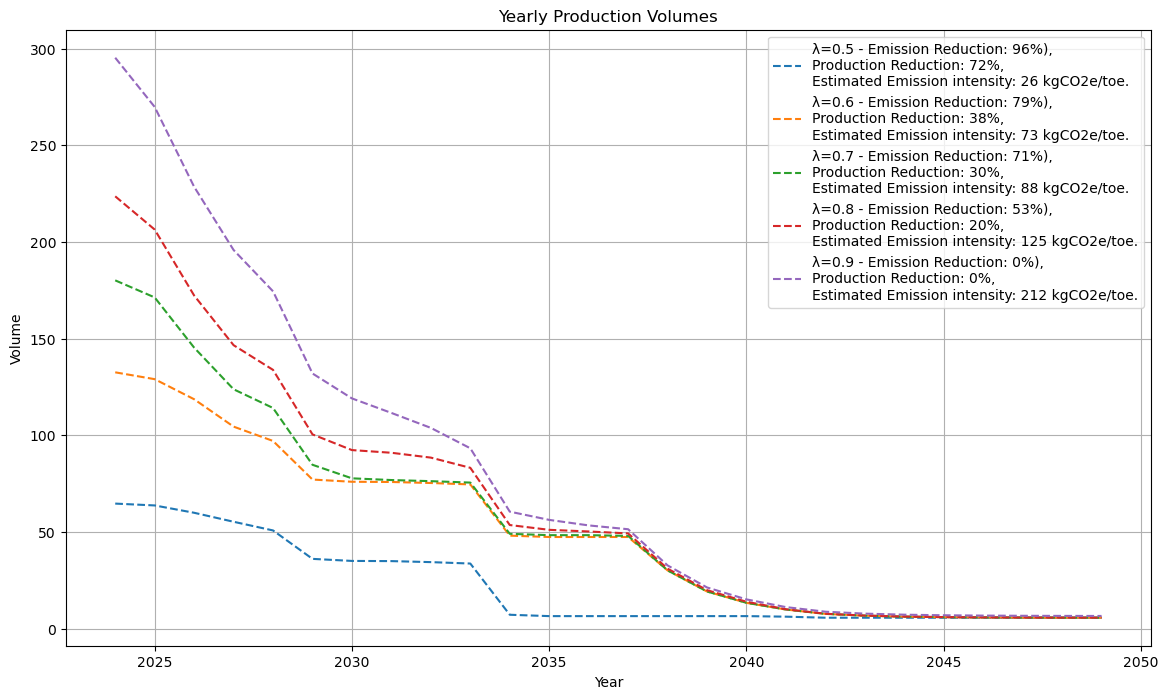

In [382]:
import matplotlib.pyplot as plt
import math

def plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime):
    # Calculate baseline emissions (all fields open)
    baseline_yearly_emissions = field_pred_data_lifetime.groupby('year')['predicted_emissions'].sum()
    baseline_total_emissions = baseline_yearly_emissions.sum()*0.84
    
    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby('year')['predicted_production'].sum()
    baseline_total_production = baseline_yearly_production.sum()
    
    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby('year')['predicted_production'].sum()
    
    plt.figure(figsize=(14, 8))

    # Iterate over the results for each lambda
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df['optimized_production'] > 0]['field'].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[field_pred_data_lifetime['field'].isin(fields_open)]
        
        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby('year')['predicted_production'].sum()
        yearly_emissions = yearly_data.groupby('year')['predicted_emissions'].sum() * 0.84
        
        # Calculate total emissions for the current lambda
        total_emissions = yearly_emissions.sum()
        total_production = yearly_production.sum()
                
        # Calculate emission reduction
        emission_reduction = np.round(((baseline_total_emissions - total_emissions) / baseline_total_emissions) * 100, 1)
        
        # Calculate production reduction
        production_reduction = np.round(((baseline_total_production - total_production) / baseline_total_production) * 100,1)
        
        # Calculate the emission intensity
        emission_intensity = np.round(total_emissions / ((total_production * 100)) if total_production != 0 else 0,1)
        
        # Plot production volumes
        plt.plot(yearly_production.index, yearly_production.values, label=f'λ={lambda_} - Emission Reduction: {math.trunc(emission_reduction)}%),\nProduction Reduction: {math.trunc(production_reduction)}%,\nEstimated Emission intensity: {math.trunc(emission_intensity)} kgCO2e/toe.', linestyle='--')
        
        # Plot emissions
        #plt.plot(yearly_emissions.index, yearly_emissions.values, label=f'Emissions (λ={lambda_}, Reduction: {emission_reduction:.2f}%)', linestyle='--')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Volume')
    plt.title('Yearly Production Volumes')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime)

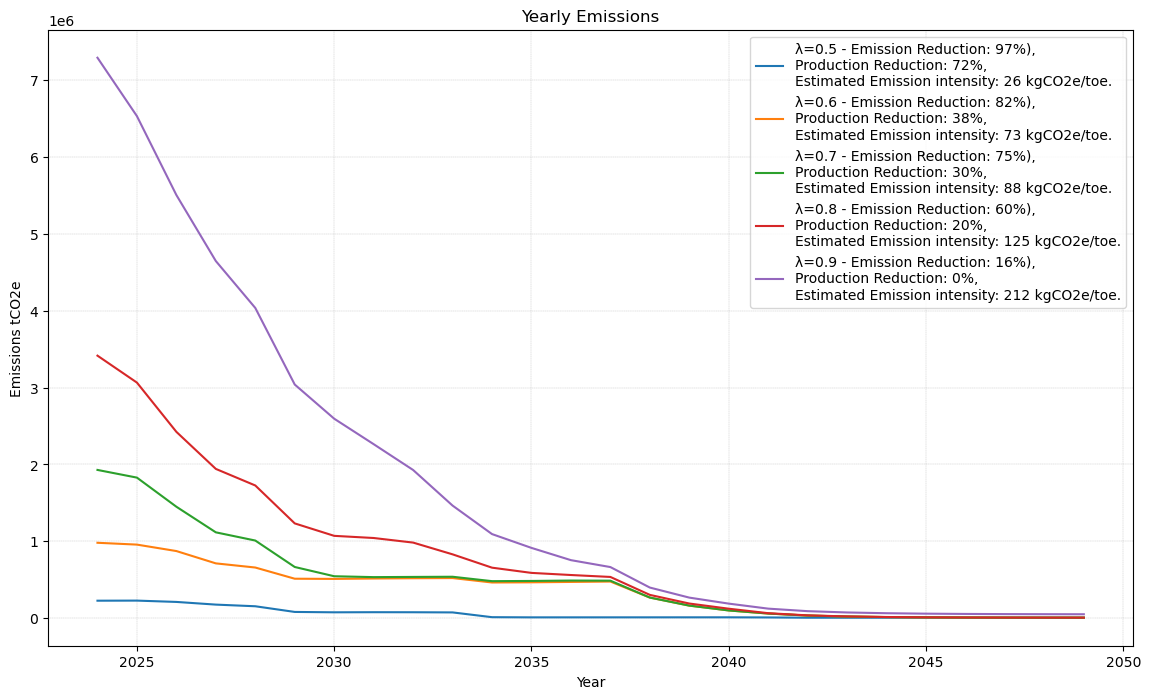

In [383]:
def plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime):
    # Calculate baseline emissions (all fields open)
    baseline_yearly_emissions = field_pred_data_lifetime.groupby('year')['predicted_emissions'].sum()
    baseline_total_emissions = baseline_yearly_emissions.sum()
    
    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby('year')['predicted_production'].sum()
    baseline_total_production = baseline_yearly_production.sum()
    
    # Calculate baseline production (all fields open)
    baseline_yearly_production = field_pred_data_lifetime.groupby('year')['predicted_production'].sum()
    
    plt.figure(figsize=(14, 8))

    # Iterate over the results for each lambda
    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df['optimized_production'] > 0]['field'].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[field_pred_data_lifetime['field'].isin(fields_open)]
        
        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby('year')['predicted_production'].sum()
        yearly_emissions = yearly_data.groupby('year')['predicted_emissions'].sum() * 0.84
        
        # Calculate total emissions for the current lambda
        total_emissions = yearly_emissions.sum()
        total_production = yearly_production.sum()
                
        # Calculate emission reduction
        emission_reduction = np.round(((baseline_total_emissions - total_emissions) / baseline_total_emissions) * 100, 1)
        
        # Calculate production reduction
        production_reduction = np.round(((baseline_total_production - total_production) / baseline_total_production) * 100,1)
        
        # Calculate the emission intensity
        emission_intensity = np.round(total_emissions / ((total_production * 100)) if total_production != 0 else 0,1)
                
        # Plot emissions
        plt.plot(yearly_emissions.index, yearly_emissions.values, label=f'λ={lambda_} - Emission Reduction: {math.trunc(emission_reduction)}%),\nProduction Reduction: {math.trunc(production_reduction)}%,\nEstimated Emission intensity: {math.trunc(emission_intensity)} kgCO2e/toe.', linestyle='-')

    # Add labels and legend
    plt.xlabel('Year')
    plt.ylabel('Emissions tCO2e')
    plt.title('Yearly Emissions')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.25)

    plt.show()

plot_yearly_production_emissions(results, lambdas, field_pred_data_lifetime)

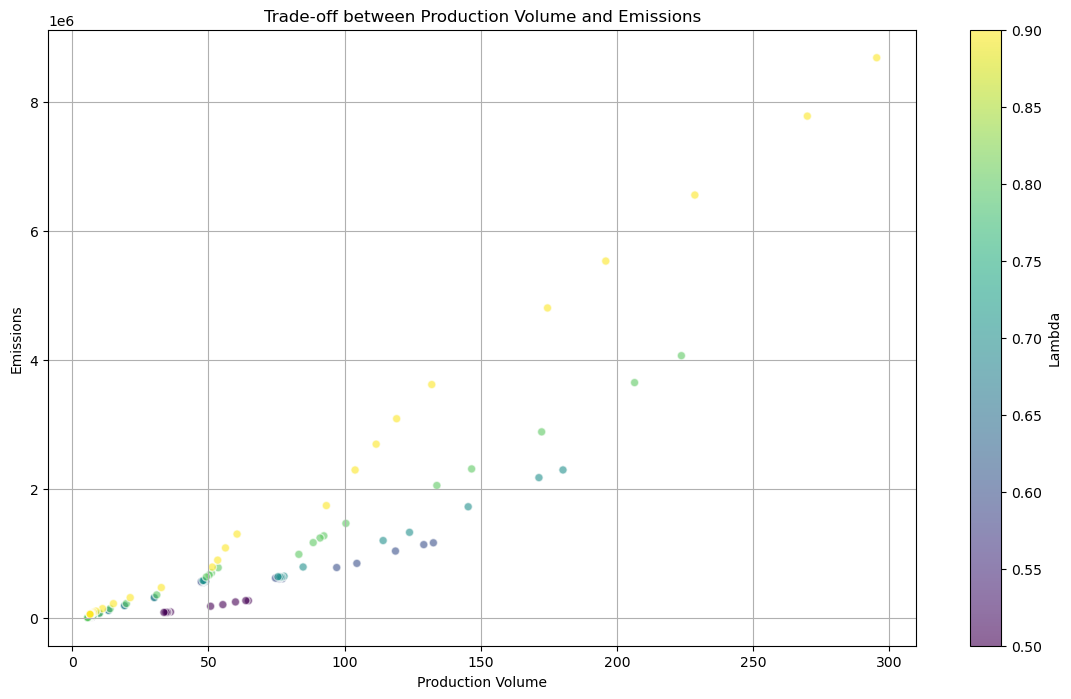

In [384]:
def plot_scatter_tradeoff(results, lambdas, field_pred_data_lifetime):
    data_points = []

    for lambda_ in lambdas:
        df = results[lambda_]
        fields_open = df[df['optimized_production'] > 0]['field'].unique()

        # Extract yearly data for open fields
        yearly_data = field_pred_data_lifetime[field_pred_data_lifetime['field'].isin(fields_open)]
        
        # Sum the production and emissions for each year
        yearly_production = yearly_data.groupby('year')['predicted_production'].sum()
        yearly_emissions = yearly_data.groupby('year')['predicted_emissions'].sum()

        for year in yearly_production.index:
            data_points.append((year, yearly_production[year], yearly_emissions[year], lambda_))

    # Convert to DataFrame for plotting
    plot_df = pd.DataFrame(data_points, columns=['Year', 'Production', 'Emissions', 'Lambda'])

    plt.figure(figsize=(14, 8))
    scatter = plt.scatter(plot_df['Production'], plot_df['Emissions'], c=plot_df['Lambda'], cmap='viridis', alpha=0.6, edgecolors='w')
    plt.xlabel('Production Volume')
    plt.ylabel('Emissions')
    plt.title('Trade-off between Production Volume and Emissions')
    cbar = plt.colorbar(scatter)
    cbar.set_label('Lambda')
    plt.grid(True)
    plt.show()

# Example usage
plot_scatter_tradeoff(results, lambdas, field_pred_data_lifetime)

In [385]:
# Checking the total production volume in 2021

field_data[field_data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()
field_data[field_data["year"] == "2021"]["net_oil_eq_prod_yearly_mill_sm3"].sum()

232.93925000000002

In [386]:
field_data

,field,year,net_oil_prod_yearly_mill_sm3,net_gas_prod_yearly_bill_sm3,net_ngl_prod_yearly_mill_sm3,net_condensate_prod_yearly_mill_sm3,net_oil_eq_prod_yearly_mill_sm3,produced_water_yearly_mill_sm3,field_id,net_oil_prod_monthly_sm3_volatility,net_gas_prod_monthly_sm3_volatility,net_ngl_prod_monthly_sm3_volatility,net_condensate_prod_monthly_sm3_volatility,net_oil_eq_prod_monthly_sm3_volatility,produced_water_in_field_volatility,status,current_status,field_owner,processing_field,field_in_emissions,facilities_lifetime_mean,facilities_lifetime_std,facilities_water_depth_mean,facilities_water_depth_std,subsea_facilites_shut_down,surface_facilites_shut_down,subsea_facilites_in_service,surface_facilites_in_service,facility_kind_multi well template,facility_kind_single well template,facility_kind_offshore wind turbine,facility_kind_subsea structure,facility_kind_fpso,facility_kind_jacket 8 legs,facility_kind_condeep monoshaft,facility_kind_loading system,facility_kind_jacket 4 legs,facility_kind_jacket tripod,facility_kind_fsu,facility_kind_semisub steel,facility_kind_condeep 4 shafts,facility_kind_landfall,facility_kind_tlp concrete,facility_kind_jack-up 3 legs,facility_kind_jacket 6 legs,facility_kind_tlp steel,facility_kind_semisub concrete,facility_kind_mopustor,facility_kind_spar,well_status_closed,well_status_drilling,well_status_injecting,well_status_junked,well_status_online/operational,well_status_p&a,well_status_plugged,well_status_producing,well_status_suspended,well_purpose_injection,well_purpose_observation,well_purpose_production,well_subsea_no,well_subsea_yes,well_final_vertical_depth_mean,well_final_vertical_depth_std,well_water_depth_mean,well_water_depth_std,investments_mill_nok,future_investments_mill_nok,yearly_co2_emissions_1000_tonnes,org_number,operator,yearly_ch4_emissions_tons,yearly_nox_emissions_tons,yearly_oil_spill_emissions_tons,yearly_water_emissions_m3,ownership_original,ownership_new_name,current_remaining_recoverable_oil,current_remaining_recoverable_gas,current_remaining_recoverable_ngl,current_remaining_recoverable_condensate,current_remaining_recoverable_oe,original_recoverable_oil,original_recoverable_gas,original_recoverable_ngl,original_recoverable_condensate,original_recoverable_oe
0,statfjord nord,1997-01-01,3.93531,0.17288,0.09230,0.00000,4.20051,0.00000,43679,0.053898,0.000405,0.000334,0.000000,0.054005,0.000000,Producing,Producing,21084.0,statfjord,True,27.5,15.0,241.75,65.030121,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,6.0,9.0,0.0,4.0,0.0,13.0,0.0,17.0,2888.8,0.000000,285.000000,0.000000,255.0,2946.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 50.0, 'Mo...","{'Equinor ASA': 1.875, 'Mobil Development Norw...",3.72,0.23,0.05,0.0,4.05,44.12,2.37,1.12,0.00,48.62
1,veslefrikk,1997-01-01,3.47468,0.13919,0.08596,0.00000,3.69981,0.00000,43618,0.052851,0.008952,0.005461,0.000000,0.053418,0.000000,Producing,Shut down,21212.0,veslefrikk,True,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111.0,0.0,0.0,69.0,6.0,36.0,111.0,0.0,3317.0,0.000000,175.000000,0.000000,229.0,0.0,156.204920,993246905.0,equinor energy as,64.319881,973.466100,88.599389,2.782760e+06,"{'Den norske stats oljeselskap a.s': 55.0, 'To...","{'Equinor ASA': 55.0, 'TotalEnergies EP Norge'...",0.00,0.00,0.00,0.0,0.00,55.34,4.19,1.81,0.00,62.97
2,frøy,1997-01-01,1.39602,0.28878,0.00000,0.01732,1.70211,0.00000,43597,0.026260,0.005287,0.000000,0.000942,0.030860,0.000000,Producing,Shut down,3810636.0,frigg,False,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,6.0,0.0,6.0,12.0,0.0,3352.2,70.481913,120.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'Den norske stats oljeselskap a.s': 53.96, 'T...","{'Equinor ASA': 53.96, 'TotalEnergies EP 

In [387]:
lifetime_pred_df

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,1.788612e+05,21.040000,450.370530,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.022249,0.000056
1,alve,2.687779e+05,4.118687,546.275563,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.033456,0.000068
2,alvheim,5.546937e+05,20.350000,1183.337554,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.069091,0.000147
3,balder,2.051904e+06,28.040000,4260.277506,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.255693,0.000531
4,bauge,2.899136e+05,6.320976,630.556186,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.036090,0.000079
...,...,...,...,...,...,...,...,...
80,visund sør,6.018080e+04,0.960281,122.949772,"POLYGON ((2.33555 61.27199, 2.33086 61.27331, ...",0.001465,0.007458,0.000015
81,volund,1.911498e+04,0.780000,37.846569,"POLYGON ((2.00307 59.44880, 1.99984 59.45090, ...",0.001176,0.002340,0.000005
82,yme,7.202156e+05,6.448206,1544.372214,"MULTIPOLYGON (((4.54792 57.77684, 4.53891 57.7...",0.010258,0.089720,0.000192
83,åsgard,1.240179e+06,42.790000,2917.724613,"MULTIPOLYGON (((6.96310 65.22484, 6.96319 65.2...",0.068485,0.154525,0.000364


In [388]:
lifetime_pred_df

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions
0,aasta hansteen,1.788612e+05,21.040000,450.370530,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.022249,0.000056
1,alve,2.687779e+05,4.118687,546.275563,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.033456,0.000068
2,alvheim,5.546937e+05,20.350000,1183.337554,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.069091,0.000147
3,balder,2.051904e+06,28.040000,4260.277506,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.255693,0.000531
4,bauge,2.899136e+05,6.320976,630.556186,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.036090,0.000079
...,...,...,...,...,...,...,...,...
80,visund sør,6.018080e+04,0.960281,122.949772,"POLYGON ((2.33555 61.27199, 2.33086 61.27331, ...",0.001465,0.007458,0.000015
81,volund,1.911498e+04,0.780000,37.846569,"POLYGON ((2.00307 59.44880, 1.99984 59.45090, ...",0.001176,0.002340,0.000005
82,yme,7.202156e+05,6.448206,1544.372214,"MULTIPOLYGON (((4.54792 57.77684, 4.53891 57.7...",0.010258,0.089720,0.000192
83,åsgard,1.240179e+06,42.790000,2917.724613,"MULTIPOLYGON (((6.96310 65.22484, 6.96319 65.2...",0.068485,0.154525,0.000364


In [389]:
lambdas

[0.5, 0.6, 0.7, 0.8, 0.9]

In [420]:
def optimize_electrification(df, lambdas, electrification_levels):
    results = {}

    for electrification_level in electrification_levels:
        num_fields = len(df)
        num_electrified_fields = int(electrification_level * num_fields / 100)

        for lambda_ in lambdas:
            # Create the OR-Tools solver
            solver = pywraplp.Solver.CreateSolver('SCIP')
            if not solver:
                raise Exception("Solver not created.")

            # Create binary decision variables for electrification
            e = [solver.BoolVar(f'e_{i}') for i in range(num_fields)]

            # Objective function: Maximize production and minimize emissions
            objective = solver.Objective()
            for i in range(num_fields):
                # Adjusted emissions
                adjusted_emissions = e[i] * df['total_lifetime_electrified_emissions'][i] + (1 - e[i]) * df['total_lifetime_emissions'][i]
                # Set the coefficients for the objective
                objective.SetCoefficient(e[i], lambda_ * df['total_lifetime_production'][i])
                objective.SetCoefficient(e[i], -(1 - lambda_) * df['total_lifetime_electrified_emissions'][i])
                objective.SetCoefficient(e[i], (1 - lambda_) * df['total_lifetime_emissions'][i])
            objective.SetMaximization()

            # Constraint: Number of electrified fields should match the specified electrification level
            solver.Add(solver.Sum(e) == num_electrified_fields)

            # Solve the problem
            status = solver.Solve()

            # Check if a solution has been found
            if status == pywraplp.Solver.OPTIMAL:
                print(f'Optimal solution found for lambda = {lambda_} and electrification level = {electrification_level}%.')
            elif status == pywraplp.Solver.FEASIBLE:
                print(f'A potentially suboptimal solution was found for lambda = {lambda_} and electrification level = {electrification_level}%.')
            else:
                print(f'No solution found for lambda = {lambda_} and electrification level = {electrification_level}%.')
                continue

            # Get the results
            electrification_decisions = [e[i].solution_value() for i in range(num_fields)]

            # Calculate optimized emissions
            optimized_emissions = (np.array(electrification_decisions) * df['total_lifetime_electrified_emissions'] +
                                   (1 - np.array(electrification_decisions)) * df['total_lifetime_emissions'])

            # Calculate optimized production (should remain the same since electrification doesn't affect production directly)
            optimized_production = df['total_lifetime_production']

            # Create a result DataFrame for the current lambda and electrification level
            result_df = df.copy()
            result_df['optimized_production'] = optimized_production
            result_df['optimized_emissions'] = optimized_emissions
            result_df['electrification_decision'] = electrification_decisions

            # Add the result DataFrame to the results dictionary
            results[(lambda_, electrification_level)] = result_df

    return results

lambdas = [0.5, 0.6, 0.7, 0.8, 0.9]
electrification_levels = [0, 5, 10, 15, 20]

results_with_electrification = optimize_electrification(df, lambdas, electrification_levels)

# Function to print fields to electrify for each combination of lambda and electrification level
def print_fields_to_electrify(results, lambdas, electrification_levels):
    for lambda_ in lambdas:
        for electrification_level in electrification_levels:
            df = results[(lambda_, electrification_level)]
            fields_electrified = df[df['electrification_decision'] == 1]['field'].unique()
            num_fields_electrified = len(fields_electrified)
            
            print(f"Lambda = {lambda_}, Electrification Level = {electrification_level}%:")
            print(f"Number of fields electrified: {num_fields_electrified}")
            print(f"Fields electrified: {fields_electrified}")
            print("\n")

# Example usage to print fields to electrify
print_fields_to_electrify(results_with_electrification, lambdas, electrification_levels)

Optimal solution found for lambda = 0.5 and electrification level = 0%.
Optimal solution found for lambda = 0.6 and electrification level = 0%.
Optimal solution found for lambda = 0.7 and electrification level = 0%.
Optimal solution found for lambda = 0.8 and electrification level = 0%.
Optimal solution found for lambda = 0.9 and electrification level = 0%.
Optimal solution found for lambda = 0.5 and electrification level = 5%.
Optimal solution found for lambda = 0.6 and electrification level = 5%.
Optimal solution found for lambda = 0.7 and electrification level = 5%.
Optimal solution found for lambda = 0.8 and electrification level = 5%.
Optimal solution found for lambda = 0.9 and electrification level = 5%.
Optimal solution found for lambda = 0.5 and electrification level = 10%.
Optimal solution found for lambda = 0.6 and electrification level = 10%.
Optimal solution found for lambda = 0.7 and electrification level = 10%.
Optimal solution found for lambda = 0.8 and electrification l

In [410]:
results_with_electrification

{(0.5,
  0):              field  total_lifetime_emissions  total_lifetime_production  \
 0   aasta hansteen              1.788612e+05                  21.040000   
 1             alve              2.687779e+05                   4.118687   
 2          alvheim              5.546937e+05                  20.350000   
 3           balder              2.051904e+06                  28.040000   
 4            bauge              2.899136e+05                   6.320976   
 ..             ...                       ...                        ...   
 80      visund sør              6.018080e+04                   0.960281   
 81          volund              1.911498e+04                   0.780000   
 82             yme              7.202156e+05                   6.448206   
 83          åsgard              1.240179e+06                  42.790000   
 84     ærfugl nord              9.808005e+03                   0.720000   
 
     total_lifetime_electrified_emissions  \
 0                           

In [411]:
def check_electrified_fields_consistency(results, lambdas, electrification_levels):
    for electrification_level in electrification_levels:
        # Initialize a dictionary to store the electrified fields for each lambda
        electrified_fields_dict = {}
        
        for lambda_ in lambdas:
            df = results[(lambda_, electrification_level)]
            fields_electrified = set(df[df['electrification_decision'] == 1]['field'].unique())
            electrified_fields_dict[lambda_] = fields_electrified
        
        # Compare the sets of electrified fields across different lambdas
        reference_lambda = lambdas[0]
        reference_fields = electrified_fields_dict[reference_lambda]
        
        consistency_flag = True
        
        for lambda_ in lambdas[1:]:
            if electrified_fields_dict[lambda_] != reference_fields:
                consistency_flag = False
                print(f"Inconsistency found for electrification level {electrification_level}% between lambda {reference_lambda} and lambda {lambda_}.")
                print(f"Fields for lambda {reference_lambda}: {reference_fields}")
                print(f"Fields for lambda {lambda_}: {electrified_fields_dict[lambda_]}\n")
        
        if consistency_flag:
            print(f"Electrified fields are consistent across all lambdas for electrification level {electrification_level}%.\n")

# Example usage
check_electrified_fields_consistency(results_with_electrification, lambdas, electrification_levels)

Electrified fields are consistent across all lambdas for electrification level 0%.

Electrified fields are consistent across all lambdas for electrification level 5%.

Electrified fields are consistent across all lambdas for electrification level 10%.

Electrified fields are consistent across all lambdas for electrification level 15%.

Electrified fields are consistent across all lambdas for electrification level 20%.



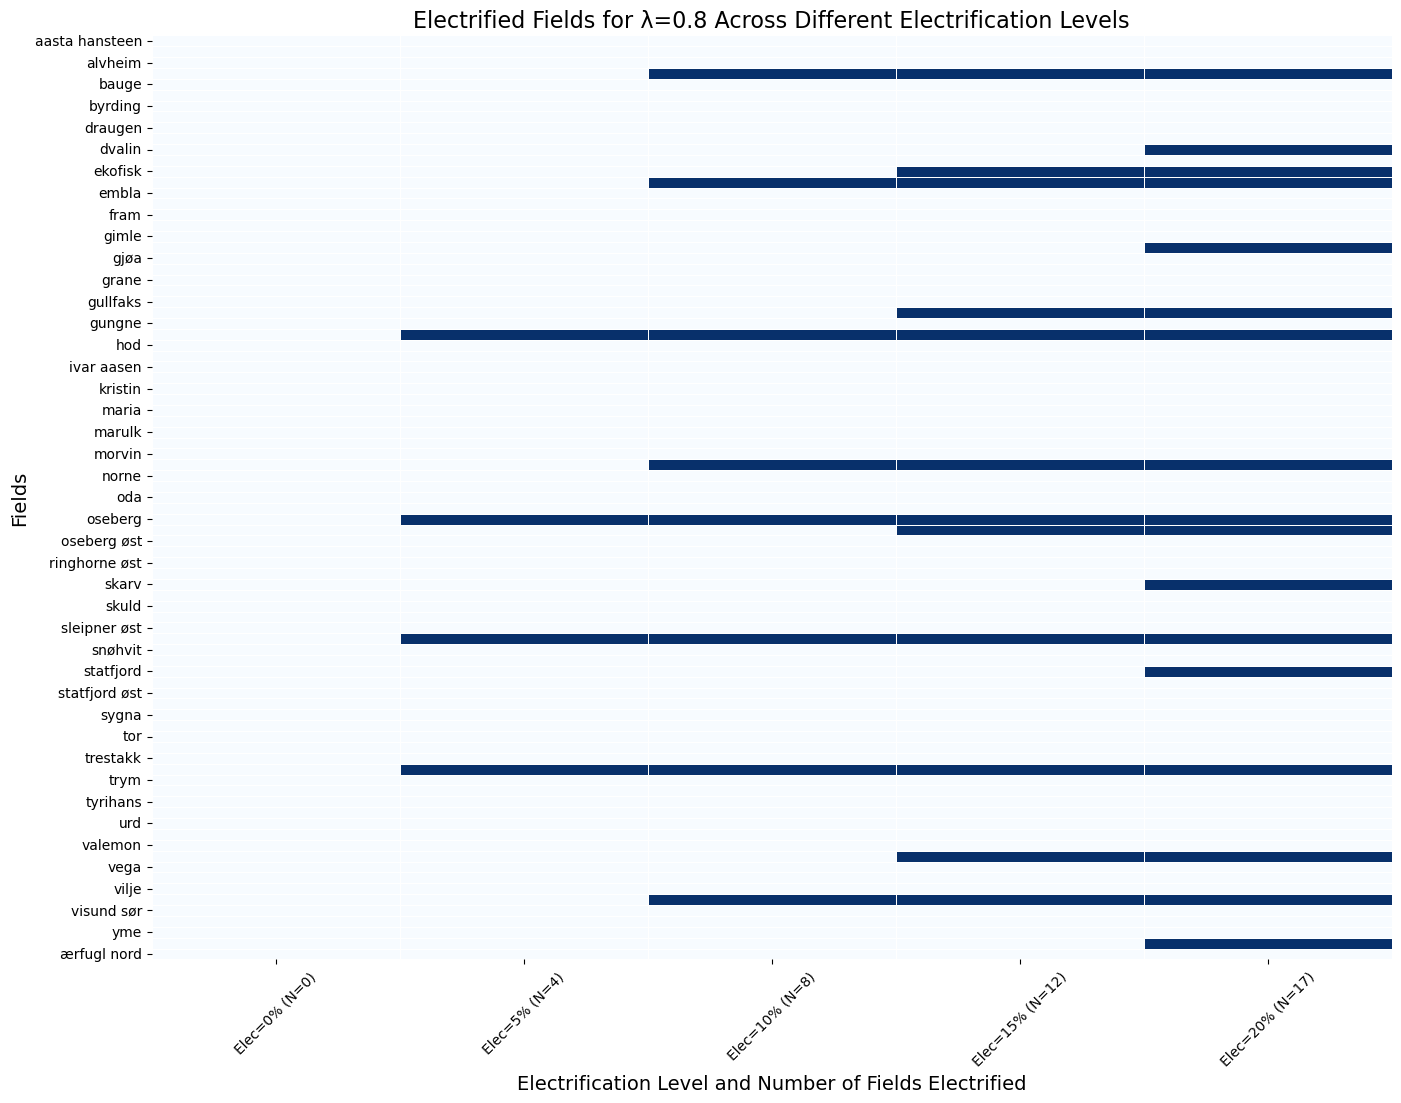

In [412]:
def prepare_heatmap_data_single_lambda(results, lambda_, electrification_levels):
    fields = results[(lambda_, electrification_levels[0])]['field'].unique()
    heatmap_data = pd.DataFrame(index=fields)

    for electrification_level in electrification_levels:
        df = results[(lambda_, electrification_level)]
        electrified = df['electrification_decision']
        num_fields_electrified = int(electrification_level * len(df) / 100)
        column_name = f'Elec={electrification_level}% (N={num_fields_electrified})'
        heatmap_data[column_name] = electrified.values

    return heatmap_data

def plot_heatmap(heatmap_data, lambda_):
    plt.figure(figsize=(16, 12))
    sns.heatmap(heatmap_data, cmap="Blues", cbar=False, linewidths=.5)
    plt.title(f'Electrified Fields for λ={lambda_} Across Different Electrification Levels', fontsize=16)
    plt.xlabel('Electrification Level and Number of Fields Electrified', fontsize=14)
    plt.ylabel('Fields', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Choose the lambda value to display
lambda_to_display = 0.8

# Prepare heatmap data for the chosen lambda
heatmap_data_single_lambda = prepare_heatmap_data_single_lambda(results_with_electrification, lambda_to_display, electrification_levels)

# Plot the heatmap
plot_heatmap(heatmap_data_single_lambda, lambda_to_display)

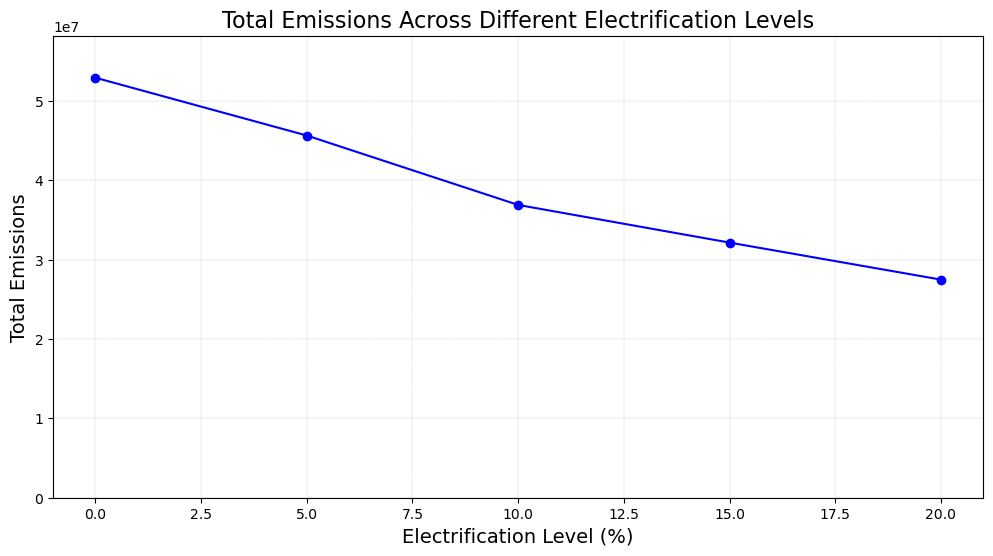

In [424]:
import matplotlib.pyplot as plt

def calculate_total_emissions(results, lambda_, electrification_levels):
    total_emissions = []

    for electrification_level in electrification_levels:
        df = results[(lambda_, electrification_level)]
        total_emissions.append(df['optimized_emissions'].sum())

    return total_emissions

def plot_total_emissions(total_emissions, electrification_levels, lambda_):
    plt.figure(figsize=(12, 6))
    plt.plot(electrification_levels, total_emissions, marker='o', linestyle='-', color='b')
    plt.title(f'Total Emissions Across Different Electrification Levels', fontsize=16)
    plt.xlabel('Electrification Level (%)', fontsize=14)
    plt.ylabel('Total Emissions', fontsize=14)
    plt.ylim(0, max(total_emissions) * 1.1)
    plt.grid(True, which='both', linestyle='--', linewidth=0.25)
    plt.show()

# Calculate total emissions for the chosen lambda
lambda_to_display = 0.8
total_emissions = calculate_total_emissions(results_with_electrification, lambda_to_display, electrification_levels)

# Plot the total emissions
plot_total_emissions(total_emissions, electrification_levels, lambda_to_display)

In [427]:
results_with_electrification[(0.5, 20)].optimized_emissions.sum()

27490771.57828608

In [428]:
# Adding the optimized_emissions column with the range of lambdas to the lifetime_pred_df as new columns for each lambda

lifetime_pred_optimized_df = lifetime_pred_df.copy()

for lambda_ in lambdas:
    lifetime_pred_optimized_df[f'optimized_emissions_{lambda_}'] = results_with_electrification[(lambda_, 20)].optimized_emissions
    
lifetime_pred_optimized_df.head(10)

,field,total_lifetime_emissions,total_lifetime_production,total_lifetime_electrified_emissions,geometry,scaled_lifetime_production,scaled_lifetime_emissions,scaled_electrified_emissions,optimized_emissions_0.5,optimized_emissions_0.6,optimized_emissions_0.7,optimized_emissions_0.8,optimized_emissions_0.9
0,aasta hansteen,1.788612e+05,21.040000,450.370530,"MULTIPOLYGON (((7.00225 67.04919, 7.00184 67.0...",0.033637,0.022249,5.604991e-05,178861.196152,178861.196152,178861.196152,178861.196152,178861.196152
1,alve,2.687779e+05,4.118687,546.275563,"MULTIPOLYGON (((7.80611 65.97710, 7.80625 65.9...",0.006526,0.033456,6.800237e-05,268777.868336,268777.868336,268777.868336,268777.868336,268777.868336
2,alvheim,5.546937e+05,20.350000,1183.337554,"MULTIPOLYGON (((1.86880 59.55038, 1.87198 59.5...",0.032531,0.069091,1.473982e-04,554693.698453,554693.698453,554693.698453,554693.698453,554693.698453
3,balder,2.051904e+06,28.040000,4260.277506,"MULTIPOLYGON (((2.37593 59.15121, 2.37463 59.1...",0.044852,0.255693,5.308714e-04,4260.277506,4260.277506,4260.277506,4260.277506,4260.277506
4,bauge,2.899136e+05,6.320976,630.556186,"POLYGON ((7.44684 64.33341, 7.44352 64.33401, ...",0.010054,0.036090,7.850611e-05,289913.568611,289913.568611,289913.568611,289913.568611,289913.568611
5,brage,3.248125e+05,2.180000,611.262281,"POLYGON ((3.03000 60.61612, 3.02991 60.61638, ...",0.003420,0.040440,7.610154e-05,324812.525520,324812.525520,324812.525520,324812.525520,324812.525520
6,byrding,1.593203e+03,0.110000,3.174983,"POLYGON ((3.52820 61.13359, 3.52803 61.13481, ...",0.000103,0.000156,3.167741e-07,1593.203035,1593.203035,1593.203035,1593.203035,1593.203035
7,bøyla,2.209211e+04,1.540000,47.347815,"POLYGON ((1.80629 59.33086, 1.80326 59.33172, ...",0.002394,0.002711,5.821950e-06,22092.105053,22092.105053,22092.105053,22092.105053,22092.105053
8,draugen,3.478229e+05,10.800000,700.675856,"MULTIPOLYGON (((7.71425 64.22451, 7.71274 64.2...",0.017230,0.043308,8.724499e-05,347822.919233,347822.919233,347822.919233,347822.919233,347822.919233
9,duva,5.160024e+04,4.881956,51600.238566,"POLYGON ((4.06266 61.37956, 4.06242 61.37965, ...",0.007749,0.006388,6.430761e-03,51600.238566,51600.238566,51600.238566,51600.238566,51600.238566
